<a href="https://colab.research.google.com/github/arthurneto2/Classificador-de-Imagens/blob/main/Trabalho_Vis%C3%A3o_Computacional.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os

import numpy as np
from skimage import util, transform, filters, color, measure, morphology
from sklearn import model_selection, neighbors, metrics, preprocessing

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Caminho para o diretório das imagens binarizadas
ds_path = '/content/drive/My Drive/mpeg7_mod'

Mounted at /content/drive


In [ ]:
# Lista das pastas na pasta 'ds_path' (nomes das classes)
classes_list = os.listdir(ds_path)

# Lista com as imagens no dataset
image_list = []
# Lista com os rótulos das imagens
label_list = []

# Lista com os nomes das imagens
filename_list_ = []

# Percorre as classes do dataset
for classe in classes_list:

    # Listagem de todas as imagens na pasta daquela classe
    filename_list = os.listdir(os.path.join(ds_path, classe))

    # Percorre os arquivos na pasta atual
    for filename in filename_list:
        # Carrega a imagem
        img_temp = plt.imread(os.path.join(ds_path, classe, filename))

        # Redimensiona a imagem para 1/4 do tamanho original
        img_temp = transform.resize(img_temp, (img_temp.shape[0]//4, img_temp.shape[1]//4), anti_aliasing=True)

        # Adiciona a imagem a lista de imagens
        image_list.append(img_temp)

        # Adiciona o rótulo da imagem à lista de rótulos
        label_list.append(classe)

        # Adiciona o nome da imagem à uma lista (para fins de visualização)
        filename_list_.append(filename)

In [ ]:
# Coverte para numpy array
label_list = np.array(label_list)
# Lista com os rótulos das imagens
print(label_list)

['bat' 'bat' 'bat' 'bat' 'bat' 'bat' 'bat' 'bat' 'bat' 'bat' 'bat' 'bat'
 'bat' 'bat' 'bat' 'bat' 'bat' 'bat' 'bat' 'bat' 'bat' 'bat' 'bat' 'bat'
 'bat' 'bat' 'bat' 'bat' 'bat' 'bat' 'bat' 'bat' 'bat' 'bat' 'bat' 'bat'
 'bat' 'bat' 'bat' 'bat' 'bat' 'bat' 'bat' 'bat' 'bat' 'bat' 'bat' 'bat'
 'bat' 'bat' 'bat' 'bat' 'bat' 'bat' 'bat' 'bat' 'bat' 'bat' 'bat' 'bat'
 'bat' 'bat' 'bat' 'bat' 'bat' 'bat' 'bat' 'bat' 'bat' 'bat' 'bat' 'bat'
 'bat' 'bat' 'bat' 'bat' 'bat' 'bat' 'bat' 'bat' 'bat' 'bat' 'bat' 'bat'
 'bat' 'bat' 'bat' 'bat' 'bat' 'bat' 'bat' 'bat' 'bat' 'bat' 'bat' 'bat'
 'bat' 'bat' 'bat' 'bat' 'beetle' 'beetle' 'beetle' 'beetle' 'beetle'
 'beetle' 'beetle' 'beetle' 'beetle' 'beetle' 'beetle' 'beetle' 'beetle'
 'beetle' 'beetle' 'beetle' 'beetle' 'beetle' 'beetle' 'beetle' 'beetle'
 'beetle' 'beetle' 'beetle' 'beetle' 'beetle' 'beetle' 'beetle' 'beetle'
 'beetle' 'beetle' 'beetle' 'beetle' 'beetle' 'beetle' 'beetle' 'beetle'
 'beetle' 'beetle' 'beetle' 'beetle' 'beetle' 'beetle'

In [ ]:
# Seleciona apenas as primeiras N imagens de cada classe
image_list_temp = []
filename_list_temp = []

# Itera pelo número de classes
for i, class_name in enumerate(classes_list):
    print(i, class_name)
    # As 6 primeiras ocorrencias em que em label_list igual a class_name.
    # Imagem.
    image_list_temp += [image_list[j] for j in np.where(label_list==class_name)[0][:6]]
    # Nome do arquivo.
    filename_list_temp += [filename_list_[j] for j in np.where(label_list==class_name)[0][:6]]

0 bat
1 beetle
2 bell
3 bone
4 apple
5 bird


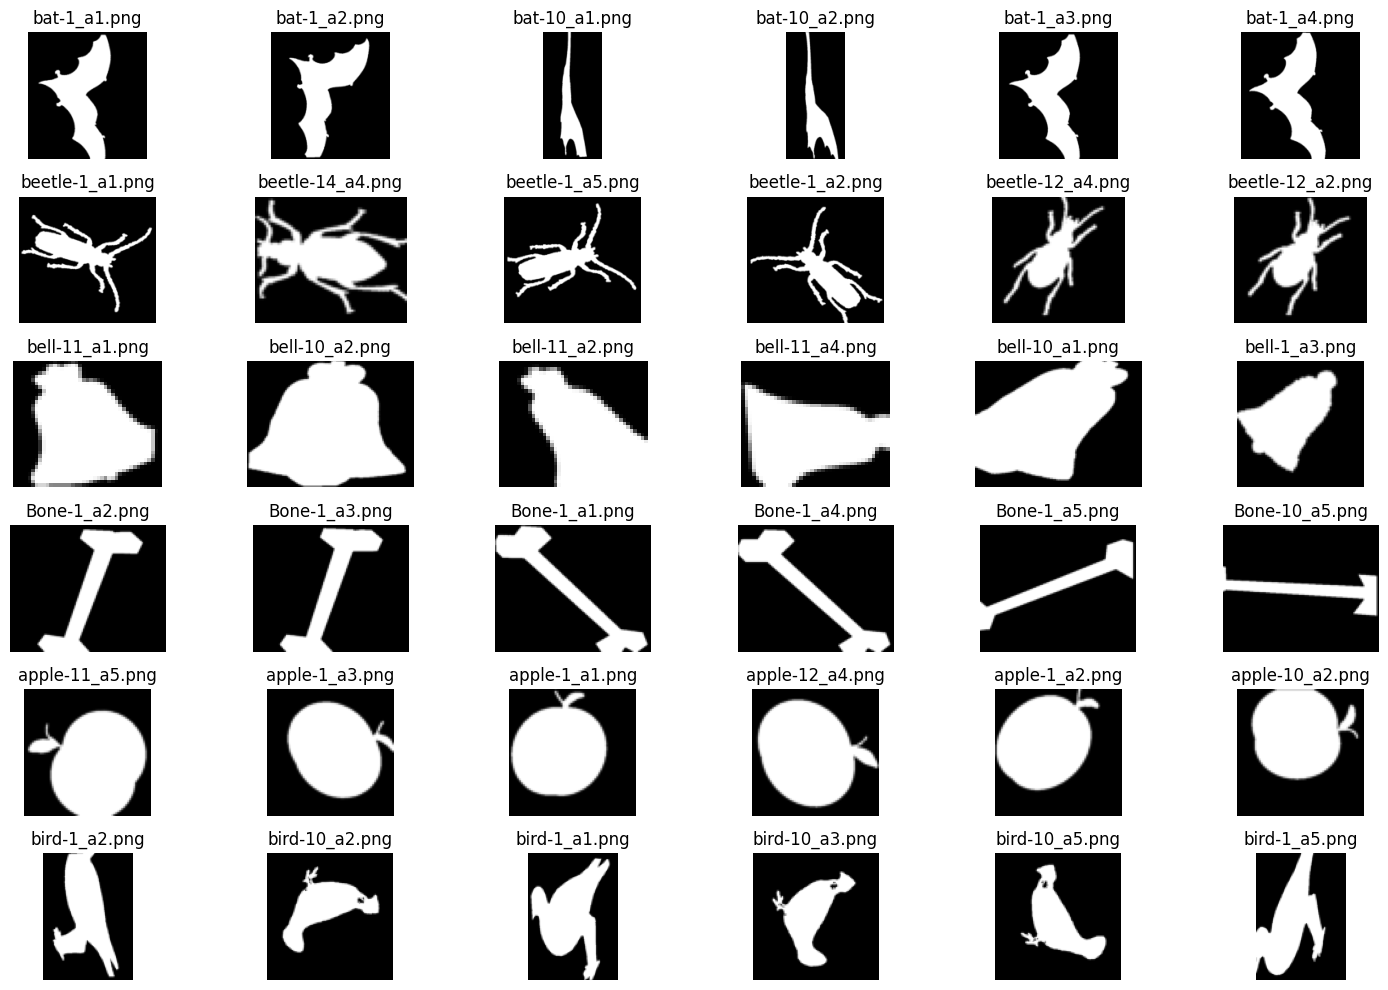

In [ ]:

fig, ax  = plt.subplots(6, 6, figsize=(15, 10))

for i, (image, filename) in enumerate(zip(image_list_temp, filename_list_temp)):
    # Verifica se a imagem é válida
    if isinstance(image, np.ndarray) and image.size > 0:
        if len(image.shape) == 3:  # Imagem RGB
            ax[i//6, i%6].imshow(image)
        elif len(image.shape) == 2:  # Imagem em escala de cinza
            ax[i//6, i%6].imshow(image, cmap='gray', vmin=0, vmax=1)  # Ajustar vmin e vmax ao intervalo dos dados
        ax[i//6, i%6].set_title(str(filename))
    else:
        ax[i//6, i%6].text(0.5, 0.5, "Imagem inválida", ha='center', va='center', color='red')
    ax[i//6, i%6].axis('off')

fig.tight_layout()
plt.show()


In [ ]:
from skimage import io, color, measure, morphology, util, filters
import numpy as np

# Nomes das caracteristicas computadas
features = ['area', 'major_axis', 'minor_axis', 'solidity', 'eccentricity']

# Lista com as imagens segmentadas (binárias)
seg_list = []

# Lista com os rótulos das imagens
list_label = []

# Matriz de características
feature_mat = []

for i, (image, label) in enumerate(zip(image_list, label_list)):
    # DEBUG
    print('Imagem {} - classe {}'.format(i, label))

    # Adiciona o rótulos (label) da imagem à lista
    list_label.append(label)

    # Segmentação da imagem
    # --------------------------------------------------
    # Converte a imagem para float
    img_float = util.img_as_float(image)

    # Verifica se a imagem já está em escala de cinza
    if len(img_float.shape) == 2:
        img_gray = img_float
    else:
        # Converte para níveis de cinza se necessário
        img_gray = color.rgb2gray(img_float)

    # Como a imagem já parece binária, não precisamos usar Otsu
    # Limpa pequenos objetos na imagem (limiar 1000 pixels para preservar a forma principal)
    img_seg = morphology.remove_small_objects(img_gray > 0, 1000)

    # Adiciona a imagem segmentada à lista
    seg_list.append(img_seg)

    # Calcula a imagem de rótulos
    im_lbl = measure.label(img_seg)

    # Calcula uma lista de propriedades (características) dos objetos na imagem
    props = measure.regionprops(im_lbl)

    # Checa se há apenas um objeto segmentado
    if len(props) != 1:
        print(f'ERRO de segmentação: {len(props)} objetos encontrados!')
        continue

    # Itera pelas propriedades computadas
    for prop in props:
        # Prop. 0: Área
        area = prop.area
        # Prop. 1: Maior eixo
        major_axis = prop.major_axis_length
        # Prop. 2: Menor eixo
        minor_axis = prop.minor_axis_length
        # Prop. 3: Solidez
        solidity = prop.solidity
        # Prop. 4: Excentricidade
        eccentricity = prop.eccentricity
        # Monta o vetor de características deste objeto
        feature_list = [area, major_axis, minor_axis, solidity, eccentricity]

    # Adiciona as características à matriz de características
    feature_mat.append(feature_list)

Imagem 0 - classe bat
Imagem 1 - classe bat
Imagem 2 - classe bat
Imagem 3 - classe bat
Imagem 4 - classe bat
Imagem 5 - classe bat
Imagem 6 - classe bat
Imagem 7 - classe bat
Imagem 8 - classe bat
Imagem 9 - classe bat
Imagem 10 - classe bat
Imagem 11 - classe bat
Imagem 12 - classe bat
Imagem 13 - classe bat
Imagem 14 - classe bat
Imagem 15 - classe bat
Imagem 16 - classe bat
Imagem 17 - classe bat
Imagem 18 - classe bat
Imagem 19 - classe bat
Imagem 20 - classe bat
Imagem 21 - classe bat
Imagem 22 - classe bat
Imagem 23 - classe bat
Imagem 24 - classe bat
Imagem 25 - classe bat
Imagem 26 - classe bat
Imagem 27 - classe bat
Imagem 28 - classe bat
Imagem 29 - classe bat
Imagem 30 - classe bat
Imagem 31 - classe bat
Imagem 32 - classe bat
Imagem 33 - classe bat
Imagem 34 - classe bat
Imagem 35 - classe bat
Imagem 36 - classe bat
Imagem 37 - classe bat
Imagem 38 - classe bat
Imagem 39 - classe bat
Imagem 40 - classe bat
Imagem 41 - classe bat
Imagem 42 - classe bat
Imagem 43 - classe ba

In [ ]:
# Converte a lista de caracteristicas para um arranjo NumPy
feature_map = np.array(feature_mat)

# Imprime a matriz de caracteristica
with np.printoptions(precision=4, suppress=True):
    print(feature_map.shape)

(543, 5)


In [ ]:
# Algumas estatisticas sobre o conjunto de caracteristicas
with np.printoptions(precision=4, suppress=True):
    print(feature_map.min(0))
    print(feature_map.max(0))
    print(feature_map.mean(0))
    print(feature_map.std(0))

[1002.       40.5195   12.0352    0.4722    0.0622]
[7780.      212.7466  105.358     0.9831    0.9947]
[2816.6851  100.2147   46.0313    0.7552    0.7777]
[1595.8352   42.1556   16.1606    0.1418    0.2071]


In [ ]:
# Seleciona apenas as primeiras N imagens de cada classe
seg_list_temp = []
filename_list_temp = []

# Itera pelo número de classes
### for i in range(3):
for i, class_name in enumerate(classes_list):
    # As 6 primeiras ocorrencias em que label é igual a 'i'.
    seg_list_temp += [seg_list[j] for j in np.where(label_list==class_name)[0][:6]]
    filename_list_temp += [filename_list_[j] for j in np.where(label_list==class_name)[0][:6]]

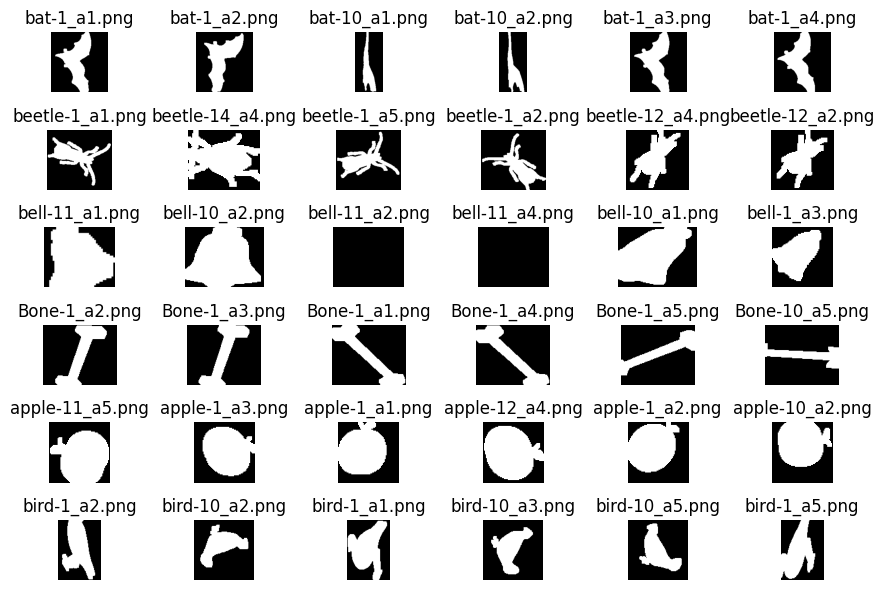

In [ ]:
fig, ax  = plt.subplots(6, 6, figsize=(9, 6))

for i, (image, filename) in enumerate(zip(seg_list_temp, filename_list_temp)):
    ax[i//6, i%6].imshow(image, cmap='gray')
    ax[i//6, i%6].set_title(str(filename))
    ax[i//6, i%6].axis('off')

fig.tight_layout()
plt.show()

In [ ]:
df = pd.DataFrame(feature_map, columns=features)
df['class'] = label_list[:len(feature_mat)]

### print(df)
display(df)

,area,major_axis,minor_axis,solidity,eccentricity,class
0,6237.0,153.633557,74.953517,0.709072,0.872915,bat
1,6414.0,159.630338,75.716121,0.693705,0.880352,bat
2,3415.0,185.086026,34.506852,0.701232,0.982467,bat
3,3743.0,181.879679,41.913557,0.667439,0.973085,bat
4,6268.0,155.043702,74.718337,0.712759,0.876216,bat
...,...,...,...,...,...,...
538,2689.0,99.304637,44.531335,0.761756,0.893817,bird
539,2680.0,99.163462,44.519667,0.758347,0.893556,bird
540,2031.0,80.837717,40.455514,0.751665,0.865763,bird
541,5497.0,114.411595,76.725104,0.722624,0.741814,bird


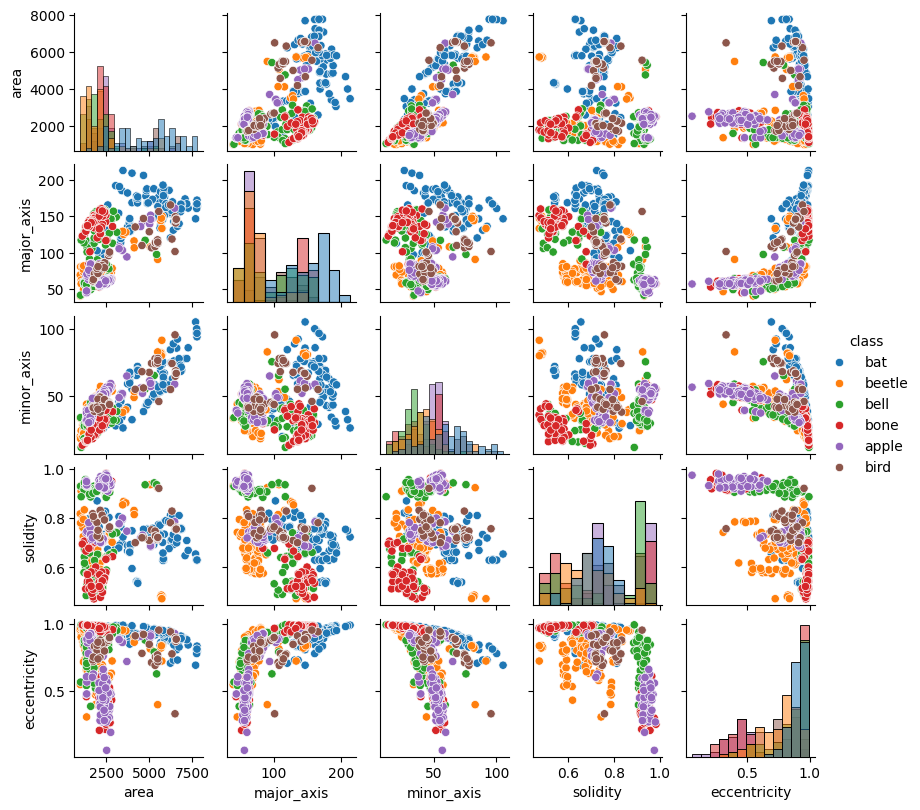

In [ ]:
g = sns.PairGrid(df, hue='class', vars=features)
g.fig.set_size_inches(8, 8)
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()

In [ ]:
# Selecionamos apenas duas caracteristicas: Área e maior-eixo
feature_mat_ok = feature_mat[:,0:2]
# Separa o conjunto de dados em 'feature_map_ok', de acordo com 'label_list'.
# 30% das imagens vão para o conjunto de testes.
# Ensure label_list is sliced to the same length as feature_mat_ok
X_train, X_test, y_train, y_test = model_selection.train_test_split(feature_mat_ok,
                                                                    label_list[:len(feature_mat_ok)], # Slice label_list to match feature_mat_ok length
                                                                    test_size=0.3,
                                                                    random_state=42)

In [ ]:
#Média das caracteristicas do conjunto de treinamento
X_train_mean = X_train.mean(0)
# Desvio padrão das caracteristicas do conjunto de treinamento
X_train_std = X_train.std(0)

with np.printoptions(precision=4, suppress=True):
    print(X_train.mean(0))
    print(X_train.std(0))

[2821.3211  100.6952]
[1623.0515   41.9842]


In [ ]:
# Transformada Normal de Caracteristicas
X_train_norm = (X_train - X_train_mean) / X_train_std
X_test_norm = (X_test - X_train_mean) / X_train_std

with np.printoptions(precision=4, suppress=True):
    print(X_train_norm.mean(0))
    print(X_test_norm.mean(0))

[0. 0.]
[-0.0095 -0.0381]


In [ ]:
# Constrói um classificador do tipo K-NN
# K = 3
clf = neighbors.KNeighborsClassifier(n_neighbors=3)

# Treinando o classificador
clf.fit(X_train_norm, y_train)

# Testando o classificador
pred = clf.predict(X_test_norm)

In [ ]:
# Acertos
acertos = y_test == pred

print('\n Predição:')
print(pred)
print('\nReal:')
print(y_test)
print('\nAcerto/Erro:')
print(acertos.astype(int))


 Predição:
['beetle' 'apple' 'apple' 'bird' 'bell' 'bat' 'bell' 'bird' 'bat' 'beetle'
 'bat' 'apple' 'apple' 'bat' 'beetle' 'bell' 'apple' 'bat' 'apple'
 'beetle' 'apple' 'beetle' 'bell' 'apple' 'beetle' 'bat' 'beetle' 'apple'
 'apple' 'bone' 'bat' 'apple' 'bat' 'bat' 'beetle' 'beetle' 'bell' 'bone'
 'apple' 'apple' 'bell' 'apple' 'beetle' 'beetle' 'apple' 'apple' 'bone'
 'bat' 'bell' 'apple' 'bat' 'bird' 'bat' 'bat' 'beetle' 'apple' 'apple'
 'beetle' 'beetle' 'beetle' 'bird' 'bell' 'bone' 'apple' 'apple' 'bird'
 'bat' 'bat' 'apple' 'apple' 'apple' 'bat' 'bone' 'bird' 'beetle' 'bat'
 'bone' 'bat' 'beetle' 'apple' 'beetle' 'bird' 'apple' 'apple' 'beetle'
 'bat' 'bat' 'bone' 'bat' 'bone' 'bell' 'bat' 'apple' 'apple' 'bell'
 'bird' 'bone' 'apple' 'bat' 'bell' 'apple' 'bat' 'bell' 'bat' 'apple'
 'beetle' 'apple' 'bat' 'bone' 'bone' 'apple' 'apple' 'bird' 'apple'
 'apple' 'apple' 'bird' 'bone' 'bell' 'bell' 'bone' 'bone' 'bird' 'beetle'
 'apple' 'bat' 'apple' 'bell' 'apple' 'bone' 'apple' 

In [ ]:
print('\nRelatório de classificação:')
print(metrics.classification_report(y_test, pred))


Relatório de classificação:
              precision    recall  f1-score   support

       apple       0.38      0.71      0.50        28
         bat       0.91      0.81      0.85        36
      beetle       0.42      0.40      0.41        25
        bell       0.52      0.41      0.46        27
        bird       0.57      0.53      0.55        15
        bone       0.75      0.47      0.58        32

    accuracy                           0.57       163
   macro avg       0.59      0.55      0.56       163
weighted avg       0.62      0.57      0.58       163



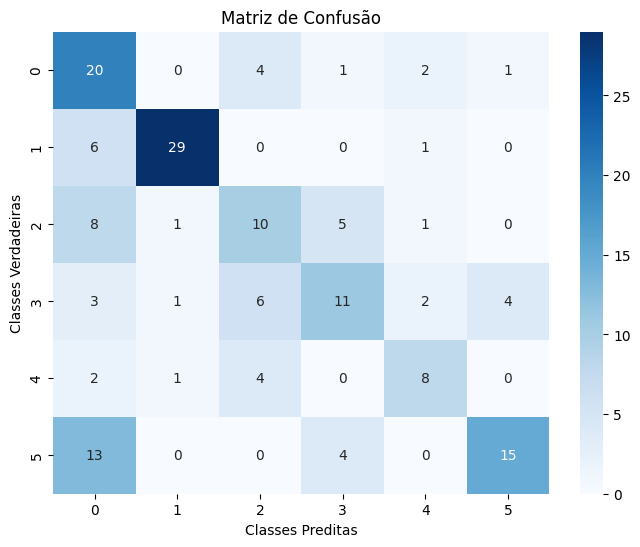

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Gerar matriz de confusão
conf_matrix = confusion_matrix(y_test, pred)

# Plotar a matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt='g')
plt.title("Matriz de Confusão")
plt.xlabel("Classes Preditas")
plt.ylabel("Classes Verdadeiras")
plt.show()

In [ ]:
from sklearn.linear_model import Perceptron
from sklearn.metrics import classification_report, accuracy_score

# Constrói um classificador do tipo Perceptron
clf = Perceptron(max_iter=1000, eta0=0.01, random_state=42)

# Treinando o classificador
clf.fit(X_train_norm, y_train)

# Testando o classificador
pred = clf.predict(X_test_norm)

In [ ]:
# Gerando o relatório de classificação
print('\nRelatório de classificação:')
print(classification_report(y_test, pred))


Relatório de classificação:
              precision    recall  f1-score   support

       apple       0.32      0.25      0.28        28
         bat       0.65      0.83      0.73        36
      beetle       0.00      0.00      0.00        25
        bell       0.23      0.78      0.35        27
        bird       0.00      0.00      0.00        15
        bone       0.00      0.00      0.00        32

    accuracy                           0.36       163
   macro avg       0.20      0.31      0.23       163
weighted avg       0.24      0.36      0.27       163



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
